In [1]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
from numba import jit
from tqdm import tqdm
from itertools import combinations, permutations
import time

In [2]:
data_C = np.loadtxt('../data/TSPC.csv', delimiter=';').astype(np.int64)
data_D = np.loadtxt('../data/TSPD.csv', delimiter=';').astype(np.int64)

In [3]:
def create_cost_matrix(data):
    x = data[:, :1]
    y = data[:, 1:2]
    cost = data[:, 2:3]
    return (((x - x.reshape(1, -1))**2 + (y - y.reshape(1, -1))**2) ** (1/2) + cost.reshape(1, -1)).round().astype(np.int64)

def create_dist_matrix(data):
    x = data[:, :1]
    y = data[:, 1:2]
    #cost = data[:, 2:3]
    return (((x - x.reshape(1, -1))**2 + (y - y.reshape(1, -1))**2) ** (1/2)).round().astype(np.int64)

In [4]:
cost_matrix_C = create_cost_matrix(data_C)

In [5]:
cost_matrix_D = create_cost_matrix(data_D)

In [6]:
dist_matrix_C = create_dist_matrix(data_C)
dist_matrix_D = create_dist_matrix(data_D)

In [7]:
def plot(data, solution):
    data_ordered = np.array([data[i] for i in solution])
    all_data = np.array([data[i] for i in range(200)])

    plt.figure(figsize=(10, 10), dpi=80)

    plt.scatter(data_ordered[:,0], data_ordered[:,1], s=data_ordered[:,2]/data_ordered[:,2].max()*200, c='b')
    plt.scatter(all_data[:,0], all_data[:,1], s=all_data[:,2]/all_data[:,2].max()*200, c='b')
    plt.plot(data_ordered[:,0], data_ordered[:,1], 'y-')
    plt.plot([data_ordered[0,0], data_ordered[-1,0]], [data_ordered[0,1], data_ordered[-1,1]], 'y-')
    plt.show()

In [8]:
def calculate_performance(cycle, cost_matrix):
    total_sum = 0
    for i in range(len(cycle)-1):
        total_sum += cost_matrix[cycle[i], cycle[i+1]]
    total_sum += cost_matrix[cycle[-1], cycle[0]]
    return total_sum

In [9]:
#@jit()
def random_solution(cost_matrix, limit=100):
    random_solution_list = list(range(0,len(cost_matrix)))
    random.shuffle(random_solution_list)
    return np.array(random_solution_list)[:limit]

solution = random_solution(cost_matrix_C, 100)
print(solution)

[152 121 126  71  18   5 190  14 184  29 119 173  26 144 195 164 155 169
 192  63 170 194  37   2  22  72  95 198 167 162 139  15  57  97  62 135
 118 115 140  48 199  90   7 157  79   1  47 147  87  31 131  50 166  92
  44 151 146  32 158 123  69  40  19  82  98  75  85 180  12   0 177 191
  54 185 181  65  55 165 136 133 124 196 160 111  21  34 128  45  61  88
 182 141  20  84 143  43   8  25 179  91]


In [10]:
#@jit()
def greedy_cycle(cost_matrix, current_id, limit=100):
    all_ids = set(list(range(0,len(cost_matrix))))
    all_ids.remove(current_id)
    solution = [current_id]
    
    for _ in range(1):
        min_val = 99999
        min_id = -1
        for next_id in all_ids:
            if cost_matrix[current_id][next_id] < min_val:
                min_val = cost_matrix[current_id][next_id]
                min_id = next_id
        solution.append(min_id)
        all_ids.remove(min_id)
        current_id = min_id
    
    while len(solution) < limit:
        min_delta = 99999
        min_id = -1
        insert_id = -1
        for i in range(len(solution)-1):
            for next_id in all_ids:
                delta = cost_matrix[solution[i]][next_id] + cost_matrix[next_id][solution[i+1]] - cost_matrix[solution[i]][solution[i+1]]
                if delta < min_delta:
                    min_delta = delta
                    min_id = next_id
                    insert_id = i
        for next_id in all_ids:
            delta = cost_matrix[solution[-1]][next_id] + cost_matrix[next_id][solution[0]] - cost_matrix[solution[-1]][solution[0]]
            if delta < min_delta:
                min_delta = delta
                min_id = next_id
                insert_id = i
        solution.insert(insert_id+1, min_id)
        all_ids.remove(min_id)

    return np.array(solution)

In [11]:
# swap node in cycle and unused node
def inter_exchange_delta(cycle, cost_matrix, used_cycle_id, unused_node):
    if used_cycle_id == len(cycle)-1:
        return cost_matrix[cycle[used_cycle_id-1], unused_node] + cost_matrix[unused_node, cycle[0]] - cost_matrix[cycle[used_cycle_id-1], cycle[used_cycle_id]] - cost_matrix[cycle[used_cycle_id], cycle[0]]
    return cost_matrix[cycle[used_cycle_id-1], unused_node] + cost_matrix[unused_node, cycle[used_cycle_id+1]] - cost_matrix[cycle[used_cycle_id-1], cycle[used_cycle_id]] - cost_matrix[cycle[used_cycle_id], cycle[used_cycle_id+1]]

In [12]:
def intra_two_nodes_exchange_delta(cycle, cost_matrix, node1, node2, pri = False):
    # print(node1, node2)
    if node1 == len(cycle)-1:
        node1plus = 0
    else:
        node1plus = node1 + 1
    
    if node2 == len(cycle)-1:
        node2plus = 0
    else:
        node2plus = node2 + 1

    if abs(node1-node2) == 1:
        if node1 > node2:
            node1, node2 = node2, node1
            node1plus, node2plus = node2plus, node1plus
        return cost_matrix[cycle[node1-1], cycle[node2]] + cost_matrix[cycle[node2], cycle[node1]] + cost_matrix[cycle[node1], cycle[node2plus]] - cost_matrix[cycle[node1-1], cycle[node1]] - cost_matrix[cycle[node1], cycle[node2]] - cost_matrix[cycle[node2], cycle[node2plus]]
    if abs(node1-node2) == len(cycle)-1:
        if node1 < node2:
            node1, node2 = node2, node1
            node1plus, node2plus = node2plus, node1plus
        return cost_matrix[cycle[node1-1], cycle[node2]] + cost_matrix[cycle[node2], cycle[node1]] + cost_matrix[cycle[node1], cycle[node2plus]] - cost_matrix[cycle[node1-1], cycle[node1]] - cost_matrix[cycle[node1], cycle[node2]] - cost_matrix[cycle[node2], cycle[node2plus]]

    return cost_matrix[cycle[node1-1], cycle[node2]] + cost_matrix[cycle[node2], cycle[node1plus]] + cost_matrix[cycle[node2-1], cycle[node1]] + cost_matrix[cycle[node1], cycle[node2plus]] - cost_matrix[cycle[node1-1], cycle[node1]] - cost_matrix[cycle[node1], cycle[node1plus]] - cost_matrix[cycle[node2-1], cycle[node2]] - cost_matrix[cycle[node2], cycle[node2plus]]

In [13]:
def intra_two_edges_exchange_delta(cycle, dist_matrix, node1, node2):
    if node1 == len(cycle)-1 or node2 == len(cycle)-1:
        return 99999
    #print(cost_matrix[cycle[node1], cycle[node2]], cost_matrix[cycle[node1+1], cycle[node2+1]], cost_matrix[cycle[node1], cycle[node1+1]], cost_matrix[cycle[node2], cycle[node2+1]])
    return dist_matrix[cycle[node1], cycle[node2]] + dist_matrix[cycle[node1+1], cycle[node2+1]] - dist_matrix[cycle[node1], cycle[node1+1]] - dist_matrix[cycle[node2], cycle[node2+1]]


In [14]:
#jit()
def steepest_local_search(cost_matrix, dist_matrix, nodes_exchange = True, initial_greedy = False, starting_node = None, cycle = None):
    if cycle is None:
        if initial_greedy:
            if starting_node:
                cycle = greedy_cycle(cost_matrix, starting_node)
            else:
                cycle = greedy_cycle(cost_matrix, random.randint(0, len(cost_matrix)-1))
        else:
            cycle = random_solution(cost_matrix)
    unused_nodes = set(list(range(0,len(cost_matrix))))
    for node in cycle:
        unused_nodes.remove(node)

    all_combinations = list(combinations(list(range(0, 100)), 2))

    while(True):
        best_delta, swap_node_a, swap_node_b, best_type = 0, None, None, None
        for used_cycle_id in range(len(cycle)):
            for unused_node in unused_nodes:
                delta = inter_exchange_delta(cycle, cost_matrix, used_cycle_id, unused_node)
                if delta < best_delta:
                    best_delta, swap_node_a, swap_node_b, best_type = delta, used_cycle_id, unused_node, 'inter_exchange'
        if nodes_exchange:
            for x, y in all_combinations:
                delta = intra_two_nodes_exchange_delta(cycle, cost_matrix, x, y)
                if delta < best_delta:
                    best_delta, swap_node_a, swap_node_b, best_type = delta, x, y, 'intra_two_nodes_exchange'
        else:
            for x, y in all_combinations:
                delta = intra_two_edges_exchange_delta(cycle, dist_matrix, x, y)
                if delta < best_delta:
                    best_delta, swap_node_a, swap_node_b, best_type = delta, x, y, 'intra_two_edges_exchange'

        if best_type is not None:
            if best_type == 'inter_exchange':
                unused_nodes.add(cycle[swap_node_a])
                unused_nodes.remove(swap_node_b)
                cycle[swap_node_a] = swap_node_b
            elif best_type == 'intra_two_nodes_exchange':
                cycle[swap_node_a], cycle[swap_node_b] = cycle[swap_node_b], cycle[swap_node_a]
            elif best_type == 'intra_two_edges_exchange':
                cycle[swap_node_a+1], cycle[swap_node_b] = cycle[swap_node_b], cycle[swap_node_a+1]
                cycle[swap_node_a+2:swap_node_b] = cycle[swap_node_a+2:swap_node_b][::-1]
        else:
            break
    return cycle

In [15]:
#jit()
def greedy_local_search(cost_matrix, dist_matrix, nodes_exchange = True, initial_greedy = False, starting_node = None, cycle = None):
    if cycle is None:
        if initial_greedy:
            if starting_node:
                cycle = greedy_cycle(cost_matrix, starting_node)
            else:
                cycle = greedy_cycle(cost_matrix, random.randint(0, len(cost_matrix)-1))
        else:
            cycle = random_solution(cost_matrix)
    unused_nodes = set(list(range(0,len(cost_matrix))))
    for node in cycle:
        unused_nodes.remove(node)

    #neighbourhood = [(x, y, 'inter') for x in range(len(cycle)) for y in unused_nodes]
    #neighbourhood += [(x, y, 'intra') for x, y in combinations(list(range(0, 100)), 2)]

    while(True):
        best_delta, swap_node_a, swap_node_b, best_type = 0, None, None, None
        neighbourhood = [(x, y, 'inter') for x in range(len(cycle)) for y in unused_nodes]
        neighbourhood += [(x, y, 'intra') for x, y in combinations(list(range(0, 100)), 2)]
        random.shuffle(neighbourhood)
        if nodes_exchange:
            for x, y, z in neighbourhood:
                if z == 'inter':
                    delta = inter_exchange_delta(cycle, cost_matrix, x, y)
                    if delta < best_delta:
                        best_delta, swap_node_a, swap_node_b, best_type = delta, x, y, 'inter_exchange'
                        break
                elif z == 'intra':
                    delta = intra_two_nodes_exchange_delta(cycle, cost_matrix, x, y)
                    if delta < best_delta:
                        best_delta, swap_node_a, swap_node_b, best_type = delta, x, y, 'intra_two_nodes_exchange'
                        break
        else:
            for x, y, z in neighbourhood:
                if z == 'inter':
                    delta = inter_exchange_delta(cycle, cost_matrix, x, y)
                    if delta < best_delta:
                        best_delta, swap_node_a, swap_node_b, best_type = delta, x, y, 'inter_exchange'
                        break
                elif z == 'intra':
                    delta = intra_two_edges_exchange_delta(cycle, dist_matrix, x, y)
                    if delta < best_delta:
                        best_delta, swap_node_a, swap_node_b, best_type = delta, x, y, 'intra_two_edges_exchange'
                        break

        if best_type is not None:
            if best_type == 'inter_exchange':
                unused_nodes.add(cycle[swap_node_a])
                unused_nodes.remove(swap_node_b)
                cycle[swap_node_a] = swap_node_b
                #neighbourhood = [(x, y) for x in range(len(cycle)) for y in unused_nodes]
            elif best_type == 'intra_two_nodes_exchange':
                cycle[swap_node_a], cycle[swap_node_b] = cycle[swap_node_b], cycle[swap_node_a]
            elif best_type == 'intra_two_edges_exchange':
                cycle[swap_node_a+1], cycle[swap_node_b] = cycle[swap_node_b], cycle[swap_node_a+1]
                cycle[swap_node_a+2:swap_node_b] = cycle[swap_node_a+2:swap_node_b][::-1]
        else:
            break
    return cycle

In [16]:
def calculate_k_regret_newest(mat, bool_mask, k, solution, weighted=False):
    total = np.array(sorted(list(set(range(200)))), dtype=np.int64)
    anti_solution = np.array(sorted(list(set(range(200)) - set(solution))))
    
    new_mat = (mat[solution][:, anti_solution].T
    + np.c_[mat[anti_solution][:, solution][:, 1:], mat[anti_solution][:, solution][:, :1]]
    - np.append(np.diagonal(mat[solution][:, solution], 1), mat[solution][:, solution][-1:, :1]).reshape(1, -1))

    biggest_regret = 0 # what's yours? 
    id_biggest = None
    
    sorted_mat = np.sort(new_mat, axis=1)

    if weighted:
        regrets = (sorted_mat[:, 1:k] - sorted_mat[:, :1]).sum(axis=1) * (1 / sorted_mat[:, :1])
    else:
        regrets = (sorted_mat[:, 1:k] - sorted_mat[:, :1]).sum(axis=1)
    
    # print(regrets.shape, sorted_mat.shape)

    biggest_regret = regrets.max()
    
    id_biggest = np.where(regrets == biggest_regret)[0][0]
    
    new_node_id = total[anti_solution][id_biggest]
    node_to_append = total[solution][np.where(new_mat[id_biggest] == new_mat[id_biggest].min())[0]][0]
    
    
    return new_node_id, node_to_append, biggest_regret


def tsp_regret(cost_matrix, solution: list, max_nodes=100, k=2, weighted=True):
    # solution_set = set([starting_node])
    # solution = list([starting_node])
    solution_set = set(solution)

    ## regular greedy
    # total = np.array(sorted(list(set(range(200)))), dtype=np.int64)
    total = np.arange(200, dtype=np.int64)
    for i in range(k-1):
        previous_node = solution[-1]
        # bool_mask = pd.Series(range(len(cost_matrix))).isin(solution_set)
        
        # bool_mask = np.array(sorted(list(set(range(200)) - set(solution))))
        bool_mask = np.array(sorted(list(set(range(200)) - solution_set)))
        matrix_id = np.where(cost_matrix[previous_node][bool_mask] == cost_matrix[previous_node][bool_mask].min())[0][0]
        #print(total[bool_mask])
        new_node = total[bool_mask][matrix_id]
        solution_set.add(new_node)
        solution.append(new_node)
    
    ## tsp with regret
    while len(solution_set) < max_nodes:
        # bool_mask_solution_nodes = pd.Series(range(len(cost_matrix))).isin(solution_set)
        new_node_id, node_to_append, regret_value = calculate_k_regret_newest(cost_matrix, k, k, np.array(solution), weighted)
        solution.insert(solution.index(node_to_append)+1, new_node_id)
        solution_set.add(new_node_id)
        
    # solution.append(solution[0])

    return np.array(solution)

In [17]:
def calculate_path(cycle, cost_matrix, start_node, path_length):
    total_sum = 0
    for i in range(start_node, start_node+path_length):
        total_sum += cost_matrix[cycle[i], cycle[i+1]]
    return total_sum

def roulette_selection(population, fitness, k):
    # calculate fitness
    fitness = np.array(fitness)
    fitness = fitness / fitness.sum()
    # fitness = np.array([30,30,30,1,1,1,1,1,1,1])
    # fitness = fitness / fitness.sum()
    # select k individuals
    return [population[i] for i in np.random.choice(len(population), size=k, p=fitness)]

In [18]:
def large_scale_neighborhood(cost_matrix, dist_matrix, local_search = True, stop_time = 10, initial_greedy = False, starting_node = None, random_destroy = False, path_length = 10, nr_of_paths = 10, nr_of_path_to_delete = 3):
    start = time.time()

    # generate initial solution
    if initial_greedy:
        if starting_node:
            cycle = greedy_cycle(cost_matrix, starting_node)
        else:
            cycle = greedy_cycle(cost_matrix, random.randint(0, len(cost_matrix)-1))
    else:
        cycle = random_solution(cost_matrix)

    # local search (optional)
    if local_search or not initial_greedy:
        cycle = steepest_local_search(cost_matrix, dist_matrix, nodes_exchange = False, cycle=cycle)

    nr_iter = 0
    # repeat
    while (time.time() - start) < stop_time:
        nr_iter += 1
        # destroy
        if random_destroy:
            random_ids = list(range(0,100))
            random.shuffle(random_ids)
            random_ids_remove = random_ids[:25]
            cycle = np.delete(cycle, random_ids_remove)
        else:
            starting_nodes = []
            paths_scores = []
            for _ in range(nr_of_paths):
                start_node = random.randint(0, 100-path_length-1)
                starting_nodes.append(start_node)
                paths_scores.append(calculate_path(cycle, cost_matrix, start_node, path_length))
            start_nodes_to_delete = roulette_selection(starting_nodes, paths_scores, nr_of_path_to_delete)
            ids_to_delete_all = []
            for id in set(start_nodes_to_delete):
                ids_to_delete_all += list(range(id, id+path_length))
            cycle = np.delete(cycle, ids_to_delete_all)
            
        # repair
        cycle = tsp_regret(cost_matrix, list(cycle))

        # local search (optional)
        if local_search:
            cycle = steepest_local_search(cost_matrix, dist_matrix, nodes_exchange = False, cycle=cycle)

    return np.array(cycle), nr_iter

In [ ]:
#path_length * nr_of_paths_to_delete = <20, 30>
path_lenghts_and_nr_of_path_to_delete = [(30, 1),(15, 2),(10, 3),(5, 6),(3, 10),(1, 30)]
nr_of_paths = [10, 30]

for path_length, nr_of_path_to_delete in path_lenghts_and_nr_of_path_to_delete:
    for nr_of_path in nr_of_paths:
        mean = 0
        for _ in range(3):
            cycle, nr_iter = large_scale_neighborhood(cost_matrix_C, dist_matrix_C, stop_time = 100, initial_greedy = False, random_destroy = False, path_length = path_length, nr_of_paths = nr_of_path, nr_of_path_to_delete = nr_of_path_to_delete)
            mean += calculate_performance(cycle, cost_matrix_C)
        print(f"mean: {mean/3}, path_length: {path_length}, nr_of_path_to_delete: {nr_of_path_to_delete}, nr_of_path: {nr_of_path}, nr_iter: {nr_iter}")


Tests

In [20]:
def plot(data, solution):
    data_ordered = np.array([data[i] for i in solution])
    all_data = np.array([data[i] for i in range(200)])

    plt.figure(figsize=(10, 10), dpi=80)

    plt.scatter(data_ordered[:,0], data_ordered[:,1], s=data_ordered[:,2]/data_ordered[:,2].max()*200, c='b')
    plt.scatter(all_data[:,0], all_data[:,1], s=all_data[:,2]/all_data[:,2].max()*200, c='b')
    plt.plot(data_ordered[:,0], data_ordered[:,1], 'y-')
    plt.plot([data_ordered[0,0], data_ordered[-1,0]], [data_ordered[0,1], data_ordered[-1,1]], 'y-')
    plt.show()

In [21]:
def present_results(min, max, average, time, iter, best_cycle):
    print("{: >10} {: >10} {: >10} {: >10} {: >10}".format('MIN', 'MAX', 'AVG', 'TIME', 'ITER'))
    print("{: >10} {: >10} {: >10} {: >10} {: >10}".format(min, max, average, time, iter))
    print()
    return best_cycle

In [24]:
# local_search(cost_matrix, inter = True, initial_greedy = False, starting_node = None)
def test_solution_lns(cost_matrix, dist_matrix, random_destroy, local_search):
    start = time.time()
    costs = []
    iter = []
    best_cost = 9999999999
    best_cycle = None
    for _ in range(2):
        cycle, nr_iter = large_scale_neighborhood(cost_matrix, dist_matrix, stop_time = 5, initial_greedy = False, random_destroy = random_destroy, local_search = local_search, path_length = 5, nr_of_paths = 30, nr_of_path_to_delete = 6)
        total_cost = calculate_performance(cycle, cost_matrix)
        costs.append(total_cost)
        iter.append(nr_iter)
        if total_cost < best_cost:
            best_cost = total_cost
            best_cycle = cycle
    costs = np.array(costs)
    iter = np.array(iter)
    return costs.min(), costs.max(), costs.mean(), time.time() - start, iter.mean(), best_cycle

local search | neighborhood | starting solutions

In [25]:
print('DATASET C')
print('RANDOM DESTROY, NO LOCAL SEARCH')
best_cycle_C1 = present_results(*test_solution_lns(cost_matrix_C, dist_matrix_C, True, False))
print('RANDOM DESTROY, LOCAL SEARCH')
best_cycle_C2 = present_results(*test_solution_lns(cost_matrix_C, dist_matrix_C, True, True))
print('HEURISTIC DESTROY, NO LOCAL SEARCH')
best_cycle_C3 = present_results(*test_solution_lns(cost_matrix_C, dist_matrix_C, False, False))
print('HEURISTIC DESTROY, LOCAL SEARCH')
best_cycle_C4 = present_results(*test_solution_lns(cost_matrix_C, dist_matrix_C, False, True))

DATASET C
RANDOM DESTROY, NO LOCAL SEARCH
       MIN        MAX        AVG       TIME       ITER
     48558      51615    50086.5 10.000188827514648      285.0

RANDOM DESTROY, LOCAL SEARCH
       MIN        MAX        AVG       TIME       ITER
     47827      48926    48376.5 10.043076992034912       39.5

HEURISTIC DESTROY, NO LOCAL SEARCH
       MIN        MAX        AVG       TIME       ITER
     49969      51406    50687.5 10.018332242965698      277.0

HEURISTIC DESTROY, LOCAL SEARCH
       MIN        MAX        AVG       TIME       ITER
     48818      48912    48865.0 10.114163875579834       35.0



In [33]:
print(best_cycle_C1)
print(best_cycle_C2)
print(best_cycle_C3)
print(best_cycle_C4)

[ 87  79 194  21 157 171 108  15 117  53  22 195  55  36 128 132 113  74
 163  61  71  20  64 185 116  27 147  96  59 143 159 164 178  19  69   0
 149  50 121  91  43  77   4 114 175 153  88 127 186  45 167 101  99 135
  51   5 112 196 134 119 109 189  75 174 177 137  41   1 152  11 160 198
 106  48  92  26   8 123 124  80  31  89  12  94  42 111  14 169  95  73
  72 190  98  66   6 156 172  24 141 144]
[ 79 194  21 171  81 180  32  62 108  15 117  53  22  55 195 113  74 163
  61  71  20  64 185 116  27 147  96  59 143 159 164 178  19  69   0 149
  50  91 121  43  77   4 114 175 153  88 127 186  45 167 101  60 174 199
 137  41 177   1  75 189 109 119 130 152  11 160 106  48  92  26   8 110
 169  95 196 135  51   5 112  73  31  14 111  42  89  94  12  72 190  98
  66 172 156   6  24  87 102 154 144 141]
[171 108  62  15 117  53  22 195  55  36 132 128  37  59  96  27 116 147
 143 159 164 178  19  69   0 149  50 121  91 114   4  77  43 192 199 174
 137  41 177   1  75 189 109 119 130 152

In [30]:
print('DATASET D')
print('RANDOM DESTROY, NO LOCAL SEARCH')
best_cycle_D1 = present_results(*test_solution_lns(cost_matrix_D, dist_matrix_D, True, False))
print('RANDOM DESTROY, LOCAL SEARCH')
best_cycle_D2 = present_results(*test_solution_lns(cost_matrix_D, dist_matrix_D, True, True))
print('HEURISTIC DESTROY, NO LOCAL SEARCH')
best_cycle_D3 = present_results(*test_solution_lns(cost_matrix_D, dist_matrix_D, False, False))
print('HEURISTIC DESTROY, LOCAL SEARCH')
best_cycle_D4 = present_results(*test_solution_lns(cost_matrix_D, dist_matrix_D, False, True))

DATASET D
RANDOM DESTROY, NO LOCAL SEARCH
       MIN        MAX        AVG       TIME       ITER
     47824      48013    47918.5 10.017008543014526      201.5

RANDOM DESTROY, LOCAL SEARCH
       MIN        MAX        AVG       TIME       ITER
     44900      45006    44953.0 10.11254620552063       41.0

HEURISTIC DESTROY, NO LOCAL SEARCH
       MIN        MAX        AVG       TIME       ITER
     47970      49011    48490.5 10.013214111328125      281.0

HEURISTIC DESTROY, LOCAL SEARCH
       MIN        MAX        AVG       TIME       ITER
     46830      47031    46930.5 10.091477870941162       22.5



In [38]:
print(best_cycle_D1)
print(best_cycle_D2)
print(best_cycle_D3)
print(best_cycle_D4)

[ 95  33 136  61  73 185 107  97 193 119  59  71 166  85 129  64 147 159
  89  58 171  72 114  67 158 162 150  44 117 196  21 192   3 156  91  70
  51 174 140 148 141 130 142  53  82  63   8 115 182 133   5  34 183 197
  31 101  38 103 131  24 127 121 179 143 122  92  99 102  37 165 137  88
  55   4 153 145 157  80  57   0 169  66 135 198 190  19  29  18  16  52
  12 109 189 181 170  47 132 172 163   2]
[163 115   8  63  82  53 142 130 141 148 140 188 174  21 192 196 117  44
 150 162 158 126  67 114  72 171  58  89 159 147  64 129  85 166  71 193
 119  59 189  47 170 136  61  73 185 132  12 107  97 139  52  18  16 172
  95 135 198 190  19  79 145 157  80 153   4  55  88  36  25 134 154 123
 165  37 137  99  57   0 169  66  26  92 122 143 179 121 127  24 131 103
  38  42 101  31 197 183  34   5   2 182]
[153   4  55  88 137 165  37 102  99  43  50  24 127 121 197 183  34 179
 143 122  92  26 169  66 128   5   2 182 163  40 115   8  63  82  53 142
 130 141 148 140 188 161 174  51  70  91

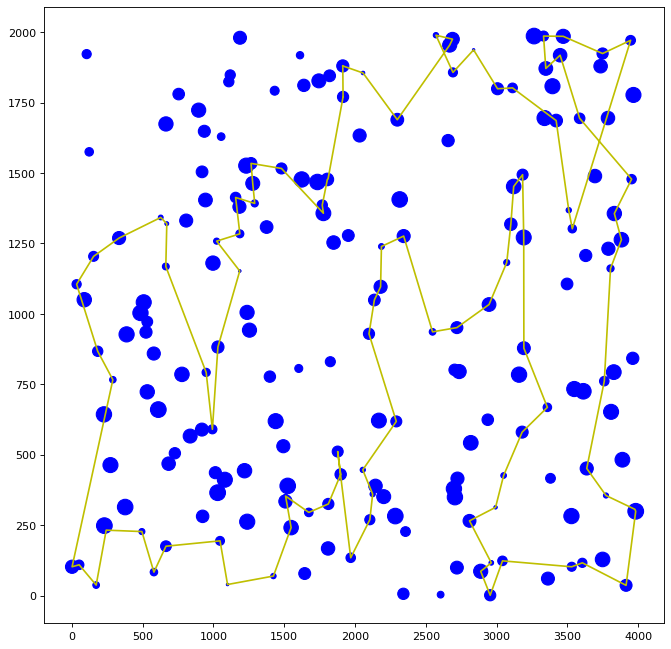

In [39]:
plot(data_C, best_cycle_C1)